# Przemysław Kaleta
Data: https://data.stanford.edu/hcmst2017

In [16]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

import xgboost as xgb

from collections import defaultdict

In [17]:
data = pd.read_stata("hcmts.dta")

Explanations of variable names taken from:

https://stacks.stanford.edu/file/druid:vt073cc9067/HCMST_2017_fresh_Codeboodk_v1.1a.pdf

* Yes/no questions:
    * **Q5** Is [Partner name] the same sex as you? 
    * **Q25_2** Did you and [Partner name] attend the same high school?
    * **Q10** Highest level of schooling of partner
    * **hcm2017q24_met_online** Met online
    
* Quantitative questions:
    * **w6_q9** partner age in 2017
    * **w6_q24_length** length of q24 how met answer in characters

In [18]:
binary_variables = ["Q5", "Q25_2", "Q26_2",  "hcm2017q24_met_online"]
continuous_variables = ["w6_q9", "w6_q24_length"]
predicted_variables = ["S1"]
variables = binary_variables + continuous_variables + predicted_variables
mydata = data.loc[data.S1.notna(), variables]

## Model

In [19]:


# Dictionary with keys as columns of categorical variables 
# and values as functions which for a given code tell us what category it is
name_from_code = defaultdict(lambda: lambda x: x)

# usage: name_from_code["column_name"](code)
# If column name is not in binary variables name_from_code["column_name"] is an identity function.

for column_name in binary_variables + predicted_variables:
    
    column = mydata[column_name].values
    
    def _name_from_code(x, col=column):
        return col.from_codes([x], col.categories)[0]
    
    name_from_code[column_name] = _name_from_code
    
    mydata[column_name] = column.codes
    


In [20]:
X, y = mydata.drop("S1", axis=1), mydata["S1"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

xgb_model = xgb.XGBClassifier(objective ='binary:logistic', colsample_bytree = 0.3, learning_rate = 0.35,
                max_depth = 5, alpha = 0, n_estimators = 100)
xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)
y_pred_train = xgb_model.predict(X_train)

def test_classifier(y_true, y_pred):
    n = len(y_true)
    print(f"Positive/negative percentages in population: {sum(y_true) / n} / {sum(y_true == 0) / n}")
    print(f"Accuracy {sum(y_true == y_pred) / n}")
    print(f"F1 score: {f1_score(y_true, y_pred)}")
    
test_classifier(y_test, y_pred)

colnames = X_train.columns
names_explained_list = ["same_sex", "high_school", "university", "met_online", "partner_age", "w6_q24_length"]
names_explained = {colname: colname_explained for colname, colname_explained in zip(colnames, names_explained_list)}

Positive/negative percentages in population: 0.405982905982906 / 0.594017094017094
Accuracy 0.8076923076923077
F1 score: 0.7283702213279677


## LIME

Spróbujemy zastosować metodę LIME do wyjaśnienia predykcji modelu.

#### Osoba 1 

In [37]:
def get_random_person(X):
    random_person = X.iloc[random.choice(range(0, len(X)))]
    random_person = pd.DataFrame([random_person.values], columns=X_train.columns)
    print(random_person)
    print("Predicted probabilities:", xgb_model.predict_proba(random_person))
    for colname, code in zip(random_person.columns, random_person.iloc[0]):
        print(names_explained[colname], name_from_code[colname](code))
    married = xgb_model.predict(random_person)
    print(married[0])
    print("S1 - prediction", name_from_code["S1"](married))
    return random_person

random.seed(11)
random_person = get_random_person(X_train)

    Q5  Q25_2  Q26_2  hcm2017q24_met_online  w6_q9  w6_q24_length
0 -1.0   -1.0   -1.0                    0.0   75.0          109.0
Predicted probabilities: [[0.93014497 0.06985502]]
same_sex nan
high_school nan
university nan
met_online no
partner_age 75.0
w6_q24_length 109.0
0
S1 - prediction Index(['Yes, I am Married'], dtype='object')


Poniższa klasa reprezentuje klasę wyjaśniającą nasz model. Wyjaśnianie opiera się na pomyśle opartym na pracy "Why Should I Trust You. Explaining the Predictions of Any Classifier".

Wyjasnianiamy predykcję dla jednej ustalonej obserwacji. Chcąc dowiedzieć się o zachowaniu się modelu dla podobnych obserwacji generujemy losowe zaburzenia dla każdej zmiennej niezależnej. Dla każdej zaburzonej obserwacji możemy dokonać predykcji naszym modelem. Ponieważ nie ma gwarancji, że powstałe obserwacje są bliskie do wyjściowej to w kolejnym etapie będziemy wyznaczali wagi bazujące na odległości (równie dobrze moglibyśmy próbkować ze zbioru danych). Budujemy model regresji logistycznej (ważonej), którą możemy łatwo interpretować - każdej zmiennej przypisana jest jedna liczba, a jej wielkość możemy interpretować jako istotność współczynnika (żeby interpretacja ta była bardziej intuicyjna warto by było znormalizować najpierw zmienne). Ponieważ zmiennych mamy mało możemy spojrzeć na każdy współczynnik. Gdyby tak nie było musielibyśmy wybierać `K` najbardziej istotnych zmiennych.

In [109]:
class Lime:
    def __init__(self, X, model, binary_variables, continuous_variables, observation, sigma=0.1, N=1000):
        """
        Accepts 
        """
        self.X = X
        self.model = model
        self.binary_variables = binary_variables
        self.continuous_variables = continuous_variables
        self.variables = self.binary_variables + self.continuous_variables
        self.means = {variable: X.mean()[variable] for variable in continuous_variables}
        self.stdevs = {variable: X.std()[variable] for variable in binary_variables + continuous_variables}
        self.mins = {variable: np.quantile(X[variable].dropna(), 0.02, interpolation="higher") for variable in continuous_variables}
        self.maxs = {variable: np.quantile(X[variable].dropna(), 0.98, interpolation="lower") for variable in continuous_variables}
        self.observation = observation.copy()
        self.sigma = sigma
        self.N = N
        
    def perturb_observation(self):
        new_observation = self.observation.copy()
        for variable in continuous_variables:
            new_observation[variable] = np.random.uniform(self.mins[variable], self.maxs[variable])
        for variable in binary_variables:
            new_observation[variable] = random.choice([-1, 0, 1])
        return new_observation
            
    def _generate_perturbed_set(self):
        SEED = 10
        random.seed(SEED)
        np.random.seed(SEED)
        self.perturbed = pd.concat([self.perturb_observation() for _ in range(self.N)])
        self.perturbed["prediction"] = self.model.predict(self.perturbed)
        
    def _observation_weight(self, perturbed_observation, sigma):
        """
        Defines distance between perturbed observation and original one.
        Since variables may have different magnitudes we divide by standard error.
        Than we compute weight for this observation in weighted regression (exponential kernel).
        """
        total_distance = 0
        for variable in self.binary_variables + self.continuous_variables:
            # observation is a data frame with one row
            total_distance += ((perturbed_observation[variable] - self.observation[variable]) / self.stdevs[variable])**2
        return np.exp(-total_distance)
    
    def get_weights(self, sigma):
        return self.perturbed.apply(lambda x: self._observation_weight(x, sigma), axis=1)[0].values
            
    def fit_simple_model(self):
        from sklearn.linear_model import SGDClassifier
        simple_model = SGDClassifier(loss="log", penalty="l2", alpha=0.001, max_iter=1000, tol=0.001)
        simple_model.fit(self.perturbed.loc[:, self.binary_variables + self.continuous_variables], self.perturbed["prediction"].values, sample_weight=self.get_weights(self.sigma))
        self.coef = simple_model.coef_[0]
        
    def plot_simple_model(self):
        plt.bar([names_explained[name] for name in self.variables], self.coef)
        plt.xticks(rotation=50)
        
    def lime(self):
        self._generate_perturbed_set()
        self.fit_simple_model()
        self.plot_simple_model()

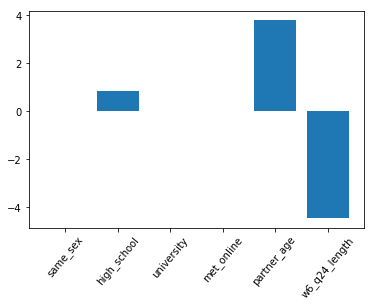

In [110]:
lime = Lime(X_train, xgb_model, binary_variables, continuous_variables, random_person)
lime.lime()

Wykres pokazuje współczynniki w modelu regresji logistycznej. Jeśli współczynnik jest dodatni to zwiększanie danej zmiennej powoduje zmniejszanie szansy na bycie ożenionym (przypomnijmy, że nasze kodowanie zmiennej wyjasnienej oznacza 0 - bycie w związku małżeńskim, 1 - nie). Muszę jednak zwrócić uwagę, że pomimo regularyzacji i prób zmieniania na przykład współczynnika sigma (który występuje przy wagach) współczynniki te zachowują się bardzo niestabilnie, w sposób zbliżony do losowego. Ponadto współczynniki binarne nie ma co zwracać uwagi, ponieważ w samym zbiorze danych było bardzo mało znanych wartości, a o braku sensowności tych zmiennych można się było już przekonać. Warto natomiast zwrócić uwage na współczynnik przy wieku, jest on dodatni. Mogłoby to sie wydawać dziwne, gdyby nie fakt, że osoba której predykcję wyjaśniamy ma już 75 lat, a wtedy dalsze zwiększanie wieku zmniejszało szanse na posiadanie (żyjącego) małżonka.

    Q5  Q25_2  Q26_2  hcm2017q24_met_online  w6_q9  w6_q24_length
0 -1.0   -1.0   -1.0                    1.0   48.0           91.0
Predicted probabilities: [[0.7741276 0.2258724]]
same_sex nan
high_school nan
university nan
met_online yes
partner_age 48.0
w6_q24_length 91.0
0
S1 - prediction Index(['Yes, I am Married'], dtype='object')


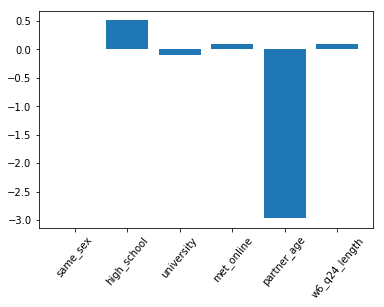

In [114]:
random.seed(1)
random_person2 = get_random_person(X_train)
lime = Lime(X_train, xgb_model, binary_variables, continuous_variables, random_person2)
lime.lime()

Tutaj dla osoby w wieku 48 lat im większy wiek, tym większa szansa na bycie w związku co ma sens.

## Podsumowanie
Podsumowując wykonaną implementację i wyniki wyjaśnień dochodze do wniosku, że trochę prostsze metody jak Partial Dependency Plots są dużo lepszym sposobem na wyjaśnianie danych tabularycznych. Doceniam jednak użyteczność pomysłu LIME dla danych obrazkowych albo tekstowych dla których trzeba dobrać odpowiedni prosty model wyjaśniający na podstawie specjalnie dobranych cech. Mółgby on też być bardziej użyteczny dla modelu budowanego na wielu zmiennych.

Po drugie przekonałem się teraz, że model, który ma teoretycznie dobre wyniki po bardziej szczegółowym przyjrzeniu się okazuje się nie aż tak dobry i podatny na błędy spowodowane na przykład niską jakością danych.